In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

from data_generators.basic_generator import BasicDataGenerator
from environments.pricing_environment import PricingEnvironment
from learners.pricing.thompson_sampling import ThompsonSampling
from learners.pricing.ucb import UCB
from learners.pricing.contextual_learner import ContextualLearner
from environments.contextual_environment import ContextualEnvironment
from utils.context_generator import ContextGenerator

In [2]:
dg = BasicDataGenerator(filename='src/basic001.json')
sel_bid = 3
fixed_clicks = np.rint(dg.get_daily_clicks(mode='aggregate')[sel_bid]).astype(int)
fixed_cost = dg.get_costs_per_click(mode='aggregate')[sel_bid]
env_params = {
    'features': dg.get_features(),
    'customer_classes': dg.get_classes(),
    'conversion_rates': dg.get_conversion_rates(mode='all'),
    'future_purchases': dg.get_future_purchases(mode='all'),
    'daily_clicks': fixed_clicks,
    'cost_per_click': fixed_cost
}
margins = dg.get_margins()
fractions = []
for cl in dg.get_classes().values():
    fractions.append(cl['fraction'])

args = {
    'arm_values': dg.get_margins()
}

In [3]:
print('\n', 15 * '-', 'SIMULATION PARAMS', '-' * 15)
T = 365
n_experiments = 10
print(f'Time horizon: {T} days')
print(f'Num. experiments: {n_experiments}')


 --------------- SIMULATION PARAMS ---------------
Time horizon: 365 days
Num. experiments: 10


In [4]:
opt_arms = []
global_opt = 0

for i, conv_rate in enumerate(dg.get_conversion_rates(mode='all')):
    opt_arm = np.argmax(margins[i] * conv_rate * (1 + dg.get_future_purchases()[i]) - fixed_cost)
    opt_value = np.max(margins[i] * conv_rate * (1 + dg.get_future_purchases()[i]) - fixed_cost)
    opt_arms.append((opt_arm, opt_value))
    global_opt += fractions[i]*opt_value

print(f'N_ARMS: {len(margins)}')
print(f'Optimal arm: {str(opt_arms)}')
print(f'Fractions: {fractions}')
print(f'Global opt: {global_opt}')

N_ARMS: 10
Optimal arm: [(1, 19.912999999999997), (0, 8.063), (0, 15.543000000000001)]
Fractions: [0.2, 0.35, 0.45]
Global opt: 13.799


In [5]:
learners_to_test = [ThompsonSampling, UCB]
rewards_per_experiment = {}
context_split_experiment = {}
for learner in learners_to_test:
    rewards_per_experiment[learner.LEARNER_NAME] = []
    context_split_experiment[learner.LEARNER_NAME] = []

print(f'N_ROUNDS: {T}')
print(f'N_EXPERIMENTS: {n_experiments}')
print(f'ALGORITHMS: {list(rewards_per_experiment.keys())}')
start_from = 60
frequency = 15
confidence = 0.001

N_ROUNDS: 365
N_EXPERIMENTS: 10
ALGORITHMS: ['TS-Pricing', 'UCB-Pricing']


In [6]:
for e in range(n_experiments):
    # Initialization of the learners to test and their related environment:
    # the list is composed of tuples (Learner, Environment)
    print(f'{"//"*12} exp#{e} {"//"*12}')
    test_instances = []
    for learner in learners_to_test:
        context_learner = ContextualLearner(dg.get_features(), learner, **args)
        test_instances.append(
            (context_learner,
            ContextualEnvironment(**env_params),
            ContextGenerator(dg.get_features(), context_learner, update_frequency=frequency, start_from=start_from, confidence=confidence))
        )
        
    for t in range(T):
        for context_learner, env, context_generator  in test_instances:
            context_learner.next_day()
            past_arms = None
            past_features = None
            month_purchases = env.get_next_purchases_at_day(t, keep=False)
            if month_purchases is not None:
                past_arms = env.get_selected_arms_at_day(t - 30, keep=False)
                past_features= env.get_collected_user_features_at_day(t - 30, keep=False)
                context_learner.update_next_purchases(past_arms,
                                                      month_purchases, 
                                                      past_features)

            pulled_arms = context_learner.pull_arms()
            daily_rewards = env.day_round(pulled_arms)
            daily_users_features = env.get_collected_user_features_at_day(t)
            daily_pulled_arms = env.get_selected_arms_at_day(t)

            context_learner.update(daily_rewards, daily_pulled_arms, daily_users_features)
            context_generator.collect_daily_data(daily_pulled_arms, daily_rewards, daily_users_features, 
                                                 next_purchases=month_purchases)
        
    for learner, _, _ in test_instances:
        learner.next_day()
        rewards_per_experiment[learner.base_learner_class.LEARNER_NAME].append(learner.get_daily_rewards())
        context_split_experiment[learner.base_learner_class.LEARNER_NAME].append(learner.get_splits_count())

//////////////////////// exp#0 ////////////////////////

-------------------- RUNNING CONTEXT GENERATOR@t=60 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-2', 'feature-1']
Analysis of the feature `feature-2`...
Analysis of the feature `feature-1`...
	Values after the split: [13.12009398390663, 13.256182021455292]
	Value before the split: 13.709671413594913


-------------------- RUNNING CONTEXT GENERATOR@t=60 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-2', 'feature-1']
Analysis of the feature `feature-2`...
Analysis of the feature `feature-1`...
	Values after the split: [9.40499061961047, 8.208511136964537]
	Value before the split: 12.175996736092149


-------------------- RUNNING CONTEXT GENERATOR@t=75 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-2', 'feature-1

	Values after the split: [4.832541323058931]
	Value before the split: 11.558559554157291

- Evaluating the Node: feature_subspace={'feature-1': True} - is_leaf=True

Features to check: ['feature-2']
Analysis of the feature `feature-2`...
	Values after the split: [7.989416059160057]
	Value before the split: 15.16043775174191


-------------------- RUNNING CONTEXT GENERATOR@t=210 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={'feature-1': False} - is_leaf=True

Features to check: ['feature-2']
Analysis of the feature `feature-2`...
	Values after the split: [11.01283849110215]
	Value before the split: 11.369842302539212


-------------------- RUNNING CONTEXT GENERATOR@t=210 --------------------
N_LEAVES: 2
- Evaluating the Node: feature_subspace={'feature-1': False} - is_leaf=True

Features to check: ['feature-2']
Analysis of the feature `feature-2`...
	Values after the split: [4.902194617579966]
	Value before the split: 11.522082318673224

- Evaluating the Node

Analysis of the feature `feature-1`...
	Values after the split: [9.979705689345803, 9.90147843766841]
	Value before the split: 13.450911347907939


-------------------- RUNNING CONTEXT GENERATOR@t=90 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-2', 'feature-1']
Analysis of the feature `feature-2`...
Analysis of the feature `feature-1`...
	Values after the split: [12.122787038906377, 12.245121230716883]
	Value before the split: 12.556368671709436


-------------------- RUNNING CONTEXT GENERATOR@t=90 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-2', 'feature-1']
Analysis of the feature `feature-2`...
Analysis of the feature `feature-1`...
	Values after the split: [12.309780182431524, 10.382559403670857]
	Value before the split: 13.376328256580491


-------------------- RUNNING CONTEXT GENERATOR@t=105 --------------------
N_LEAVES: 1
- Eval

	Values after the split: [10.795634117802269]
	Value before the split: 11.149042616679038

- Evaluating the Node: feature_subspace={'feature-1': True} - is_leaf=True

Features to check: ['feature-2']
Analysis of the feature `feature-2`...
	Values after the split: [14.6414618665478]
	Value before the split: 15.145485406916746


-------------------- RUNNING CONTEXT GENERATOR@t=225 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-2', 'feature-1']
Analysis of the feature `feature-2`...
Analysis of the feature `feature-1`...
	Values after the split: [8.90191154958023, 9.481876375250723]
	Value before the split: 12.824361459370166


-------------------- RUNNING CONTEXT GENERATOR@t=240 --------------------
N_LEAVES: 2
- Evaluating the Node: feature_subspace={'feature-1': False} - is_leaf=True

Features to check: ['feature-2']
Analysis of the feature `feature-2`...
	Values after the split: [10.725563643513134]
	Value befor


-------------------- RUNNING CONTEXT GENERATOR@t=360 --------------------
N_LEAVES: 2
- Evaluating the Node: feature_subspace={'feature-1': False} - is_leaf=True

Features to check: ['feature-2']
Analysis of the feature `feature-2`...
	Values after the split: [10.677881492158424]
	Value before the split: 10.952176988396937

- Evaluating the Node: feature_subspace={'feature-1': True} - is_leaf=True

Features to check: ['feature-2']
Analysis of the feature `feature-2`...
	Values after the split: [14.959361900050155]
	Value before the split: 15.370108876521915


-------------------- RUNNING CONTEXT GENERATOR@t=360 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-2', 'feature-1']
Analysis of the feature `feature-2`...
Analysis of the feature `feature-1`...
	Values after the split: [8.471205536580804, 8.718537843487086]
	Value before the split: 12.748375296085484

//////////////////////// exp#2 ////////////////////////

	Values after the split: [14.424042603006548]
	Value before the split: 15.006630466199631


-------------------- RUNNING CONTEXT GENERATOR@t=165 --------------------
N_LEAVES: 2
- Evaluating the Node: feature_subspace={'feature-2': False} - is_leaf=True

Features to check: ['feature-1']
Analysis of the feature `feature-1`...
	Values after the split: [5.328655287874337]
	Value before the split: 11.176031016001039

- Evaluating the Node: feature_subspace={'feature-2': True} - is_leaf=True

Features to check: ['feature-1']
Analysis of the feature `feature-1`...
	Values after the split: [10.52983736734355]
	Value before the split: 14.514299648564782


-------------------- RUNNING CONTEXT GENERATOR@t=180 --------------------
N_LEAVES: 2
- Evaluating the Node: feature_subspace={'feature-1': False} - is_leaf=True

Features to check: ['feature-2']
Analysis of the feature `feature-2`...
	Values after the split: [10.90547938028757]
	Value before the split: 11.29438700760716

- Evaluating the Nod

	Values after the split: [10.952955224102926]
	Value before the split: 11.253142499755869

- Evaluating the Node: feature_subspace={'feature-1': True} - is_leaf=True

Features to check: ['feature-2']
Analysis of the feature `feature-2`...
	Values after the split: [14.486126322483873]
	Value before the split: 14.887946888523079


-------------------- RUNNING CONTEXT GENERATOR@t=300 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={'feature-2': False} - is_leaf=True

Features to check: ['feature-1']
Analysis of the feature `feature-1`...
	Values after the split: [3.318171210796977]
	Value before the split: 10.956533513564247


-------------------- RUNNING CONTEXT GENERATOR@t=315 --------------------
N_LEAVES: 2
- Evaluating the Node: feature_subspace={'feature-1': False} - is_leaf=True

Features to check: ['feature-2']
Analysis of the feature `feature-2`...
	Values after the split: [10.927100972919552]
	Value before the split: 11.219592451245635

- Evaluating the 

Analysis of the feature `feature-1`...
	Values after the split: [9.697312212390683, 9.603412394558273]
	Value before the split: 13.037870352215961


-------------------- RUNNING CONTEXT GENERATOR@t=135 --------------------
N_LEAVES: 2
- Evaluating the Node: feature_subspace={'feature-1': False} - is_leaf=True

Features to check: ['feature-2']
Analysis of the feature `feature-2`...
	Values after the split: [10.986794578795346]
	Value before the split: 11.43707026295625

- Evaluating the Node: feature_subspace={'feature-1': True} - is_leaf=True

Features to check: ['feature-2']
Analysis of the feature `feature-2`...
	Values after the split: [14.859528019080908]
	Value before the split: 15.518352282519663


-------------------- RUNNING CONTEXT GENERATOR@t=135 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-2', 'feature-1']
Analysis of the feature `feature-2`...
Analysis of the feature `feature-1`...
	Values after the

Analysis of the feature `feature-1`...
	Values after the split: [6.684402813979981, 10.153223309485892]
	Value before the split: 12.886150854827607


-------------------- RUNNING CONTEXT GENERATOR@t=270 --------------------
N_LEAVES: 2
- Evaluating the Node: feature_subspace={'feature-1': False} - is_leaf=True

Features to check: ['feature-2']
Analysis of the feature `feature-2`...
	Values after the split: [10.961993844593778]
	Value before the split: 11.277424588795991

- Evaluating the Node: feature_subspace={'feature-1': True} - is_leaf=True

Features to check: ['feature-2']
Analysis of the feature `feature-2`...
	Values after the split: [14.868393082240646]
	Value before the split: 15.201064277866022


-------------------- RUNNING CONTEXT GENERATOR@t=270 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-2', 'feature-1']
Analysis of the feature `feature-2`...
Analysis of the feature `feature-1`...
	Values after t

Analysis of the feature `feature-1`...
	Values after the split: [12.133004287735616, 9.585232345990145]
	Value before the split: 12.361422588345805


-------------------- RUNNING CONTEXT GENERATOR@t=90 --------------------
N_LEAVES: 2
- Evaluating the Node: feature_subspace={'feature-1': False} - is_leaf=True

Features to check: ['feature-2']
Analysis of the feature `feature-2`...
	Values after the split: [10.647512888554973]
	Value before the split: 11.049797648673751

- Evaluating the Node: feature_subspace={'feature-1': True} - is_leaf=True

Features to check: ['feature-2']
Analysis of the feature `feature-2`...
	Values after the split: [14.40180268577489]
	Value before the split: 15.224065820551477


-------------------- RUNNING CONTEXT GENERATOR@t=90 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-2', 'feature-1']
Analysis of the feature `feature-2`...
Analysis of the feature `feature-1`...
	Values after the 

Analysis of the feature `feature-1`...
	Values after the split: [10.166235607153762, 7.528465424861102]
	Value before the split: 12.594295991624724


-------------------- RUNNING CONTEXT GENERATOR@t=225 --------------------
N_LEAVES: 2
- Evaluating the Node: feature_subspace={'feature-1': False} - is_leaf=True

Features to check: ['feature-2']
Analysis of the feature `feature-2`...
	Values after the split: [10.62606792256644]
	Value before the split: 10.964609020261381

- Evaluating the Node: feature_subspace={'feature-1': True} - is_leaf=True

Features to check: ['feature-2']
Analysis of the feature `feature-2`...
	Values after the split: [14.631483608537447]
	Value before the split: 15.120821904085625


-------------------- RUNNING CONTEXT GENERATOR@t=225 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-2', 'feature-1']
Analysis of the feature `feature-2`...
Analysis of the feature `feature-1`...
	Values after th

Analysis of the feature `feature-1`...
	Values after the split: [8.783080888492034, 7.503771664323359]
	Value before the split: 12.10303305185965


-------------------- RUNNING CONTEXT GENERATOR@t=360 --------------------
N_LEAVES: 2
- Evaluating the Node: feature_subspace={'feature-1': False} - is_leaf=True

Features to check: ['feature-2']
Analysis of the feature `feature-2`...
	Values after the split: [10.582136735432933]
	Value before the split: 10.845358514658306

- Evaluating the Node: feature_subspace={'feature-1': True} - is_leaf=True

Features to check: ['feature-2']
Analysis of the feature `feature-2`...
	Values after the split: [15.000610554097653]
	Value before the split: 15.216575402704732


-------------------- RUNNING CONTEXT GENERATOR@t=360 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-2', 'feature-1']
Analysis of the feature `feature-2`...
Analysis of the feature `feature-1`...
	Values after the

Analysis of the feature `feature-1`...
	Values after the split: [7.9716021385399705, 7.5716183670830315]
	Value before the split: 12.671964245062686


-------------------- RUNNING CONTEXT GENERATOR@t=180 --------------------
N_LEAVES: 2
- Evaluating the Node: feature_subspace={'feature-2': False} - is_leaf=True

Features to check: ['feature-1']
Analysis of the feature `feature-1`...
	Values after the split: [10.638148376922178]
	Value before the split: 11.013567540380114

- Evaluating the Node: feature_subspace={'feature-2': True} - is_leaf=True

Features to check: ['feature-1']
Analysis of the feature `feature-1`...
	Values after the split: [14.830276066855726]
	Value before the split: 15.146562843497803


-------------------- RUNNING CONTEXT GENERATOR@t=180 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-2', 'feature-1']
Analysis of the feature `feature-2`...
Analysis of the feature `feature-1`...
	Values after 

Analysis of the feature `feature-1`...
	Values after the split: [10.02378730144225, 6.856387601859067]
	Value before the split: 12.627630445145824


-------------------- RUNNING CONTEXT GENERATOR@t=315 --------------------
N_LEAVES: 2
- Evaluating the Node: feature_subspace={'feature-2': False} - is_leaf=True

Features to check: ['feature-1']
Analysis of the feature `feature-1`...
	Values after the split: [10.396134970478647]
	Value before the split: 10.670268329232936

- Evaluating the Node: feature_subspace={'feature-2': True} - is_leaf=True

Features to check: ['feature-1']
Analysis of the feature `feature-1`...
	Values after the split: [14.867624156558925]
	Value before the split: 15.305253215401208


-------------------- RUNNING CONTEXT GENERATOR@t=315 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-2', 'feature-1']
Analysis of the feature `feature-2`...
Analysis of the feature `feature-1`...
	Values after th

Analysis of the feature `feature-1`...
	Values after the split: [9.550156094084198, 9.26791166087223]
	Value before the split: 11.70759418464035


-------------------- RUNNING CONTEXT GENERATOR@t=135 --------------------
N_LEAVES: 2
- Evaluating the Node: feature_subspace={'feature-1': False} - is_leaf=True

Features to check: ['feature-2']
Analysis of the feature `feature-2`...
	Values after the split: [11.069437437964156]
	Value before the split: 11.514205973546378

- Evaluating the Node: feature_subspace={'feature-1': True} - is_leaf=True

Features to check: ['feature-2']
Analysis of the feature `feature-2`...
	Values after the split: [14.592530329478937]
	Value before the split: 15.255635069359624


-------------------- RUNNING CONTEXT GENERATOR@t=135 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-2', 'feature-1']
Analysis of the feature `feature-2`...
Analysis of the feature `feature-1`...
	Values after the 

Analysis of the feature `feature-1`...
	Values after the split: [8.371663583486097, 6.188160989685668]
	Value before the split: 11.212767871501427


-------------------- RUNNING CONTEXT GENERATOR@t=270 --------------------
N_LEAVES: 2
- Evaluating the Node: feature_subspace={'feature-1': False} - is_leaf=True

Features to check: ['feature-2']
Analysis of the feature `feature-2`...
	Values after the split: [10.71687322417759]
	Value before the split: 11.023938013025113

- Evaluating the Node: feature_subspace={'feature-1': True} - is_leaf=True

Features to check: ['feature-2']
Analysis of the feature `feature-2`...
	Values after the split: [14.854505643178744]
	Value before the split: 15.278513964876984


-------------------- RUNNING CONTEXT GENERATOR@t=270 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-2', 'feature-1']
Analysis of the feature `feature-2`...
Analysis of the feature `feature-1`...
	Values after the

	Values after the split: [8.386251799179082, 11.144714182459037]
	Value before the split: 12.579453789092806


-------------------- RUNNING CONTEXT GENERATOR@t=90 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-2', 'feature-1']
Analysis of the feature `feature-2`...
Analysis of the feature `feature-1`...
	Values after the split: [12.09459049664812, 12.179900076533858]
	Value before the split: 12.41771559925584


-------------------- RUNNING CONTEXT GENERATOR@t=90 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-2', 'feature-1']
Analysis of the feature `feature-2`...
Analysis of the feature `feature-1`...
	Values after the split: [8.462282875846217, 10.920267596061315]
	Value before the split: 12.423436949520603


-------------------- RUNNING CONTEXT GENERATOR@t=105 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - i

Analysis of the feature `feature-1`...
	Values after the split: [8.752196027380622, 7.957218973802725]
	Value before the split: 8.408967928231592

	best_feature='feature-2'
NEW CONTEXT GENERATED:
 splitting into -> {'feature-2': False} and {'feature-2': True}

-------------------- RUNNING CONTEXT GENERATOR@t=255 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-2', 'feature-1']
Analysis of the feature `feature-2`...
Analysis of the feature `feature-1`...
	Values after the split: [12.414734814130869, 12.378460936665842]
	Value before the split: 12.535020459262633


-------------------- RUNNING CONTEXT GENERATOR@t=255 --------------------
N_LEAVES: 2
- Evaluating the Node: feature_subspace={'feature-2': False} - is_leaf=True

Features to check: ['feature-1']
Analysis of the feature `feature-1`...
	Values after the split: [4.011075627286722]
	Value before the split: 4.109714880415646

- Evaluating the Node: feature_sub

Analysis of the feature `feature-1`...
	Values after the split: [7.939039184236444, 8.856622238508445]
	Value before the split: 11.737618109750143


-------------------- RUNNING CONTEXT GENERATOR@t=75 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-2', 'feature-1']
Analysis of the feature `feature-2`...
Analysis of the feature `feature-1`...
	Values after the split: [12.930692207301217, 13.241032616299183]
	Value before the split: 12.962652219763743

	best_feature='feature-1'
NEW CONTEXT GENERATED:
 splitting into -> {'feature-1': False} and {'feature-1': True}

-------------------- RUNNING CONTEXT GENERATOR@t=75 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-2', 'feature-1']
Analysis of the feature `feature-2`...
Analysis of the feature `feature-1`...
	Values after the split: [7.980907942105298, 7.928970023965782]
	Value before the split: 8

Analysis of the feature `feature-1`...
	Values after the split: [9.746702517508908, 9.51517827751551]
	Value before the split: 12.161929898812566


-------------------- RUNNING CONTEXT GENERATOR@t=210 --------------------
N_LEAVES: 2
- Evaluating the Node: feature_subspace={'feature-1': False} - is_leaf=True

Features to check: ['feature-2']
Analysis of the feature `feature-2`...
	Values after the split: [11.00774850970414]
	Value before the split: 11.365325627434803

- Evaluating the Node: feature_subspace={'feature-1': True} - is_leaf=True

Features to check: ['feature-2']
Analysis of the feature `feature-2`...
	Values after the split: [14.920540409559692]
	Value before the split: 15.42169108940192


-------------------- RUNNING CONTEXT GENERATOR@t=210 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-2', 'feature-1']
Analysis of the feature `feature-2`...
Analysis of the feature `feature-1`...
	Values after the s

Analysis of the feature `feature-1`...
	Values after the split: [7.831594173581386, 10.120019322831816]
	Value before the split: 12.77574629137399


-------------------- RUNNING CONTEXT GENERATOR@t=345 --------------------
N_LEAVES: 2
- Evaluating the Node: feature_subspace={'feature-1': False} - is_leaf=True

Features to check: ['feature-2']
Analysis of the feature `feature-2`...
	Values after the split: [10.984593690225832]
	Value before the split: 11.255312408192303

- Evaluating the Node: feature_subspace={'feature-1': True} - is_leaf=True

Features to check: ['feature-2']
Analysis of the feature `feature-2`...
	Values after the split: [15.00692582926558]
	Value before the split: 15.322028177211154


-------------------- RUNNING CONTEXT GENERATOR@t=345 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-2', 'feature-1']
Analysis of the feature `feature-2`...
Analysis of the feature `feature-1`...
	Values after the

Analysis of the feature `feature-1`...
	Values after the split: [12.885745871735256, 12.769332131660025]
	Value before the split: 12.924011014407826


-------------------- RUNNING CONTEXT GENERATOR@t=165 --------------------
N_LEAVES: 2
- Evaluating the Node: feature_subspace={'feature-1': False} - is_leaf=True

Features to check: ['feature-2']
Analysis of the feature `feature-2`...
	Values after the split: [5.092300501725635]
	Value before the split: 11.642100530557292

- Evaluating the Node: feature_subspace={'feature-1': True} - is_leaf=True

Features to check: ['feature-2']
Analysis of the feature `feature-2`...
	Values after the split: [9.97474220965018]
	Value before the split: 15.379606325689124


-------------------- RUNNING CONTEXT GENERATOR@t=180 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-2', 'feature-1']
Analysis of the feature `feature-2`...
Analysis of the feature `feature-1`...
	Values after the


-------------------- RUNNING CONTEXT GENERATOR@t=300 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-2', 'feature-1']
Analysis of the feature `feature-2`...
Analysis of the feature `feature-1`...
	Values after the split: [12.762777219592824, 12.77880659175326]
	Value before the split: 12.75865293857952

	best_feature='feature-1'
NEW CONTEXT GENERATED:
 splitting into -> {'feature-1': False} and {'feature-1': True}

-------------------- RUNNING CONTEXT GENERATOR@t=300 --------------------
N_LEAVES: 2
- Evaluating the Node: feature_subspace={'feature-1': False} - is_leaf=True

Features to check: ['feature-2']
Analysis of the feature `feature-2`...
	Values after the split: [5.71478594146018]
	Value before the split: 11.296323396133262

- Evaluating the Node: feature_subspace={'feature-1': True} - is_leaf=True

Features to check: ['feature-2']
Analysis of the feature `feature-2`...
	Values after the split: [10.974636

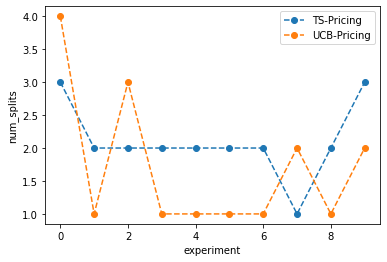

In [11]:
plt.figure()
plt.ylabel("num_splits")
plt.xlabel("experiment")
for val in context_split_experiment.values():
    plt.plot(val, '--o')
plt.legend(context_split_experiment.keys())
plt.show()

In [8]:
for key in context_split_experiment:
    print(f'{key}: avg splits -> {np.mean(context_split_experiment[key])}')

TS-Pricing: avg splits -> 2.1
UCB-Pricing: avg splits -> 1.7


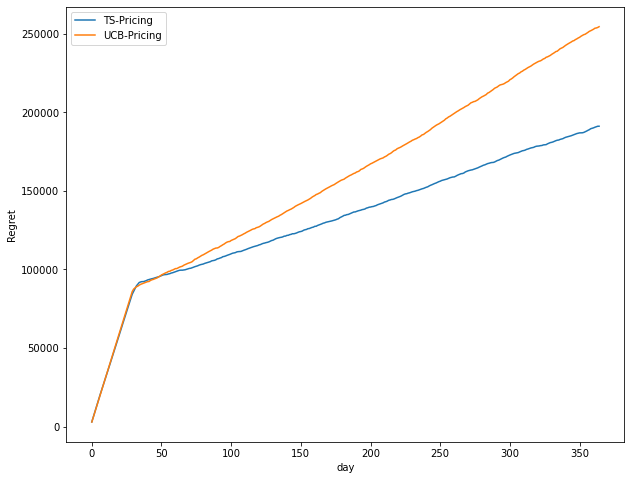

In [9]:
# Plotting the results
plt.figure(figsize=(10,8))
plt.ylabel("Regret")
plt.xlabel("day")
opt = global_opt * fixed_clicks
for val in rewards_per_experiment.values():
    plt.plot(np.cumsum(np.mean(opt - val, axis=0)))
plt.legend(rewards_per_experiment.keys())
plt.show()

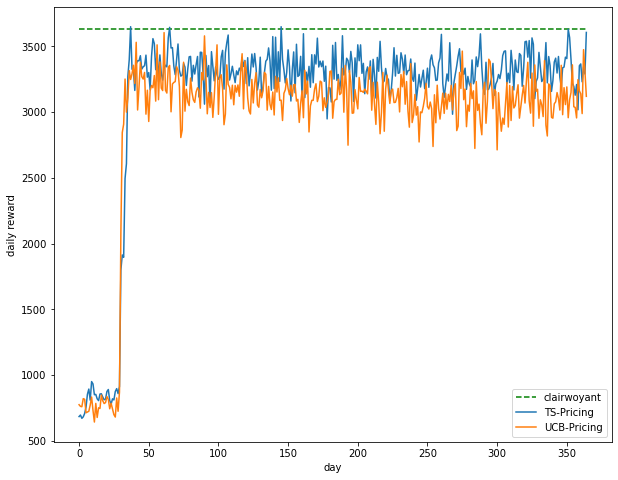

In [10]:
plt.figure(figsize=(10,8))
plt.xlabel("day")
plt.ylabel("daily reward")
plt.plot([opt]*365, '--g', label='clairwoyant')
for key in rewards_per_experiment:
    plt.plot(np.mean(rewards_per_experiment[key], axis=0), label=key)
plt.legend(loc='best')
plt.show()